<a href="https://colab.research.google.com/github/dD2405/Intro_to_TensorFlow/blob/master/6_Transfer_Learning_with_TensorFlow_Hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Hub and Transfer Learning

[TensorFlow Hub](http://tensorflow.org/hub) is an online repository of already trained TensorFlow models that you can use.
These models can either be used as is, or they can be used for Transfer Learning.

Transfer learning is a process where you take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs.

In this Colab we will do both.

Here, you can see all the models available in [TensorFlow Module Hub](https://tfhub.dev/).

## Concepts that will be covered in this Colab

1. Use a TensorFlow Hub model for prediction.
2. Use a TensorFlow Hub model for Dogs vs. Cats dataset.
3. Do simple transfer learning with TensorFlow Hub.

Before starting this Colab, you should reset the Colab environment by selecting `Runtime -> Reset all runtimes...` from menu above.

In [0]:
from __future__ import division, unicode_literals, absolute_import, print_function

In [2]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Part 1: Use a TensorFlow Hub MobileNet for prediction




In this part of the Colab, we'll take a trained model, load it into to Keras, and try it out.

The model that we'll use is MobileNet v2 (but any model from [tf2 compatible image classifier URL from tfhub.dev](https://tfhub.dev/s?q=tf2&module-type=image-classification) would work).

## Download the classifier

Download the MobileNet model and create a Keras model from it.
MobileNet is expecting images of 224 $\times$ 224 pixels, in 3 color channels (RGB).

In [0]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))])

## Run it on a single image


MobileNet has been trained on the ImageNet dataset. ImageNet has 1000 different output classes, and one of them is military uniforms.
Let's get an image containing a military uniform that is not part of ImageNet, and see if our model can predict that it is a military uniform.

65536/61306 [================================] - 0s 0us/step


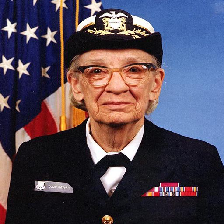

In [6]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES,IMAGE_RES))
grace_hopper

In [7]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Remember, models always want a batch of images to process. So here, we add a batch dimension, and pass the image to the model for prediction.

In [8]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax. But how can we know what class this actually is and in particular if that class ID in the ImageNet dataset denotes a military uniform or something else?

In [9]:
result

array([[ 0.17920303,  1.2696182 , -0.3149821 , ...,  0.6060541 ,
        -0.4299778 ,  0.11200593]], dtype=float32)

In [10]:
# axis = -1 or axis = 0, both can be used to access the max value of column 
predicted_class = np.argmax(result[0], axis = -1)
predicted_class

653

## Decode the predictions

To see what our predicted_class is in the ImageNet dataset, download the ImageNet labels and fetch the row that the model predicted.

16384/10484 [==============================================] - 0s 0us/step


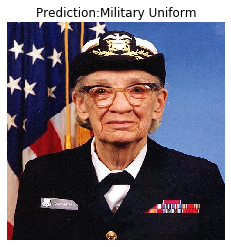

In [11]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class] 
_ = plt.title("Prediction:" + predicted_class_name.title())


# Part 2: Use a TensorFlow Hub models for the Cats vs. Dogs dataset

Now we'll use the full MobileNet model and see how it can perform on the Dogs vs. Cats dataset.

## Dataset

We can use TensorFlow Datasets to load the Dogs vs Cats dataset.

In [12]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


The images in the Dogs vs. Cats dataset are not all the same size.



In [13]:
for i, example_image in enumerate(train_examples.take(5)):
    print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (500, 343, 3)
Image 2 shape: (375, 500, 3)
Image 3 shape: (375, 500, 3)
Image 4 shape: (150, 200, 3)
Image 5 shape: (375, 500, 3)


So we need to reformat all images to the resolution expected by MobileNet (224, 224).



The `.repeat()` and `steps_per_epoch` here is not required, but saves ~15s per epoch, since the shuffle-buffer only has to cold-start once.

In [0]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Run the classifier on a batch of images

Remember our `model` object is still the full MobileNet model trained on ImageNet, so it has 1000 possible output classes.
ImageNet has a lot of dogs and cats in it, so let's see if it can predict the images in our Dogs vs. Cats dataset.


In [15]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Egyptian cat', 'mink', 'Egyptian cat', 'bloodhound', 'Chihuahua',
       'tabby', 'Siamese cat', 'papillon', 'kuvasz', 'kelpie', 'keeshond',
       'Chesapeake Bay retriever', 'basset', 'miniature schnauzer',
       'golden retriever', 'Persian cat', 'Persian cat', 'Egyptian cat',
       'tiger cat', 'German shepherd', 'Egyptian cat', 'Tibetan mastiff',
       'printer', 'redbone', 'tabby', 'wallaby', 'bluetick',
       'Persian cat', 'Great Pyrenees', 'Great Dane', 'tabby',
       'Persian cat'], dtype='<U30')

The labels seem to match names of Dogs and Cats. Let's now plot the images from our Dogs vs Cats dataset and put the ImageNet labels next to them.

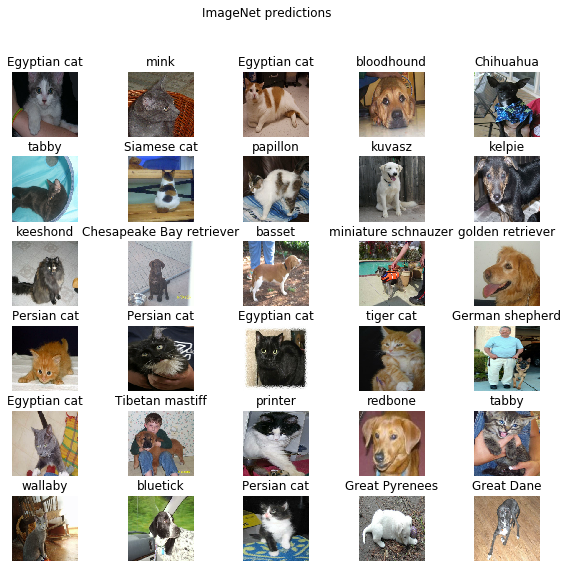

In [16]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# Part 3: Do simple transfer learning with TensorFlow Hub

Let's now use TensorFlow Hub to do Transfer Learning.

With transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

In addition to complete models, TensorFlow Hub also distributes models without the last classification layer. These can be used to easily do transfer learning. We will continue using MobileNet v2 because in later parts of this course, we will take this model and deploy it on a mobile device using [TensorFlow Lite](https://www.tensorflow.org/lite). Any [image feature vector URL from tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) would work here.

We'll also continue to use the Dogs vs Cats dataset, so we will be able to compare the performance of this model against the ones we created from scratch earlier.

Note that we're calling the partial model from TensorFlow Hub (without the final classification layer) a `feature_extractor`. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution. That is, it has extracted the features of the image.